# Estimating Zestimate logerror with Clustering

<img src="img/zillow_cluster.jpg" width=800 height=800 />

In [1]:
# Import data manipulation libraries
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import stats and modeling
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans


# Import personal modules
import wrangle_zillow
import explore
import model

import warnings
warnings.filterwarnings("ignore")

# Overall Project Plan
## Business Goals
- Construct an ML Regression model that predicts logerror of Single Family Properties using features from the Zillow Dataset. If possible construct features manually through intuition of the data and also by finding groups through ML clustering.
- Uncover what the drivers of the logerror in the zestimate value of for single family properties.
- Deliver a report to the data science team that will consist of a notebook demo of the discoveries I made.
- Make recommendations on what works or doesn't work in logerror of the zestimate.
---
## Data Science Pipeline

- [**Acquire**](#data-acquisition) data from the Codeup SQL Database. 
    - Initial inquiry into the data to see the shape and layout of things.
- Clean and [**prepare**](#data-preparation) data for the explore phase. Create wrangle.py to store functions I create to automate the full process of acquisition, cleaning and preparation. Separate train, validate, test subsets and scaled data.
- Begin [**exploration**](#data-exploration-(exploratory-data-analysis)) of the data and ask questions leading to clarity of what is happening in the data. 
    - Find interactions between independent variables and the target variable using visualization and statistical testing.
    - Use clustering to explore the data. Provide a conclusion, supported by statistical testing and visualization on whether or not the clusters are helpful/useful. At least 3 combinations of features for clustering should be tried.
- At least 4 different [**models**](#modeling) are created and their performance is compared.
    - Evaluate models on train and validate datasets. Do further hyperparamter tuning to find the best performing models.
    - Choose the model with that performs the best. Do any final tweaking of the model. Automate modeling functions and put them into a model.py file.
- Evaluate final model on the test dataset.
---
## Presentation
- Construct a Final Report Notebook wherein I show how I arrived at the MVP model. Throughout the notebook, document conclusions, takeaways, and next steps.
- Present my findings to my data science team using said Final Report Notebook.
    - [**Conclusions, takeaways, next steps**](#conclusions,-recommendations,-next-steps)
---
## Github repo
- Create README.md with data dictionary, project and business goals, initial hypothesis and an executive summary

# Executive Summary
- The features found to be key drivers of the logerror for Single Family Properties were:
    - Certain seasons in which the house was sold was a good predictor: Spring and Fall.
    - Yearbuilt to tax amount ratio
    - Certain days of the week in which the house was sold was a good predictor: namely Sunday.
- Again, homes in Los Angeles county were more disparate than homes on either Orange or Ventura counties and thus every model produced worse predictions for homes in Los Angeles county than Ventura or Orange counties.

**Recommendations**

- The further exploration of the data and subsequent modeling show that while certain groups were helpful in estimating logerror more accurately, the differences were small and not really that predictive. 
    - I would need further time to continue exploring to find any meaningful clusters; though it should be noted that after iterating through about 50000 cluster combinations, it's possible there are not any signficiant clusters which would help increase predictive power of a model for logerror.
- Further examination of the Aggregate Model vs Individual Model for results is needed.

# Data Acquisition
Explored the SQL database for relevant features and acquired desired data.

In [2]:
# Using self made function to access data from SQL into a dataframe
df = wrangle_zillow.get_zillow()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52319 entries, 0 to 52318
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52319 non-null  int64  
 1   airconditioningtypeid         13615 non-null  float64
 2   architecturalstyletypeid      70 non-null     float64
 3   basementsqft                  47 non-null     float64
 4   bathroomcnt                   52319 non-null  float64
 5   bedroomcnt                    52319 non-null  float64
 6   buildingclasstypeid           0 non-null      float64
 7   buildingqualitytypeid         33654 non-null  float64
 8   calculatedbathnbr             52184 non-null  float64
 9   decktypeid                    389 non-null    float64
 10  finishedfloor1squarefeet      4371 non-null   float64
 11  calculatedfinishedsquarefeet  52238 non-null  float64
 12  finishedsquarefeet12          52073 non-null  float64
 13  f

# Data-Preparation

Through initial data exploration and analysis, I decided to clean the data with the following steps:
- Where a column had more than 5% null values it was dropped.
- Where a row had more than 5% null values it was dropped.
- Multiple columns were redundant, unhelpful or found to be not needed through exploration of the data. These were dropped.
- Dropped all rows where the data was invalid, wrong, or incorrectly entered.
- Dropped all entries where sq footage value was smaller than a theoretical minimum.
- Certain datatypes were converted for memory efficiency and/or usage in modeling.
- Ran an outlier function that dropped all outliers with that had a Z score of 4 or above.


In [3]:
# Using self made function to clean and reformat dataframe.
df = wrangle_zillow.clean_zillow(df)
df.head()

,bathrooms,bedrooms,square_footage,county,latitude,longitude,lot_size,yearbuilt,structure_tax_value,tax_value,land_tax_value,taxamount,logerror,transactiondate
0,3.5,4,3100,orange,33634931.0,-117869207.0,4506.0,1998,485713.0,1023282.0,537569.0,11013.72,0.025595,2017-01-01
1,1.0,2,1465,ventura,34449266.0,-119281531.0,12647.0,1967,88000.0,464000.0,376000.0,5672.48,0.055619,2017-01-01
2,2.0,3,1243,orange,33886168.0,-117823170.0,8432.0,1962,85289.0,564778.0,479489.0,6488.30,0.005383,2017-01-01
3,3.0,4,2376,los_angeles,34245180.0,-118240722.0,13038.0,1970,108918.0,145143.0,36225.0,1777.51,-0.103410,2017-01-01
5,1.0,2,738,los_angeles,34149214.0,-118239357.0,4214.0,1922,18890.0,218552.0,199662.0,2366.08,0.101723,2017-01-01


Certain features were engineered both manually and synthetically through clustering. Adding those features as columns here and encoding any necessary data.

In [4]:
df = explore.add_new_columns(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42136 entries, 0 to 52318
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   bathrooms                       42136 non-null  float16       
 1   bedrooms                        42136 non-null  uint8         
 2   square_footage                  42136 non-null  uint16        
 3   county                          42136 non-null  object        
 4   latitude                        42136 non-null  float64       
 5   longitude                       42136 non-null  float64       
 6   lot_size                        42136 non-null  float64       
 7   yearbuilt                       42136 non-null  uint16        
 8   structure_tax_value             42136 non-null  float64       
 9   tax_value                       42136 non-null  float64       
 10  land_tax_value                  42136 non-null  float64       
 11  ta

I end up with a dataframe of 42136  entries and 33 features.

In [5]:
# Setting columns to scale.
columns_to_scale = ['bathrooms','bedrooms','square_footage','latitude','longitude','lot_size','yearbuilt',
 'structure_tax_value','tax_value','land_tax_value','taxamount','scaledyear_to_scaledtax',
 'home_price_per_sq_ft','land_price_per_lot_sq_ft', 'summer_scaledyear_to_scaledtax', 'sunday_fall']

In [6]:
# Running a function that will scale the data and provide me with a train, validate, test split of unscaled data for exploratory
# data analysis and a scaled version of train, validate, test for modeling later.

train, validate, test, train_scaled, validate_scaled, test_scaled = wrangle_zillow.prepare_all_data(df, columns_to_scale)

In [7]:
# Showing sample of train subset to be used in visualization
train.head()

,bathrooms,bedrooms,square_footage,county,latitude,longitude,lot_size,yearbuilt,structure_tax_value,tax_value,...,season_winter,day_of_week_friday,day_of_week_monday,day_of_week_saturday,day_of_week_sunday,day_of_week_thursday,day_of_week_tuesday,day_of_week_wednesday,summer_scaledyear_to_scaledtax,sunday_fall
35454,3.0,5,3014,los_angeles,34634772.0,-118223018.0,13099.0,2000,275543.0,344453.0,...,0,1,0,0,0,0,0,0,0,0
3249,1.0,3,1192,los_angeles,33869289.0,-118392007.0,4146.0,1951,79980.0,399937.0,...,1,0,1,0,0,0,0,0,0,0
40108,2.0,3,1589,ventura,34186509.0,-118938855.0,10500.0,1964,156181.0,260296.0,...,0,1,0,0,0,0,0,0,0,0
8843,2.0,3,1527,los_angeles,34159441.0,-118433721.0,5899.0,1948,167500.0,837507.0,...,1,0,0,0,0,0,1,0,0,0
15343,1.0,3,1116,los_angeles,33741754.0,-118300309.0,4994.0,1955,84740.0,153030.0,...,0,0,1,0,0,0,0,0,0,0


In [8]:
# Showing sample of same data in train_scaled subset to be used in modeling
train_scaled.head()

,bathrooms,bedrooms,square_footage,county,latitude,longitude,lot_size,yearbuilt,structure_tax_value,tax_value,...,season_winter,day_of_week_friday,day_of_week_monday,day_of_week_saturday,day_of_week_sunday,day_of_week_thursday,day_of_week_tuesday,day_of_week_wednesday,summer_scaledyear_to_scaledtax,sunday_fall
35454,0.571429,0.571429,0.592411,los_angeles,0.939364,0.652026,0.869616,0.890511,0.231125,0.195190,...,0,1,0,0,0,0,0,0,0.0,0.0
3249,0.000000,0.285714,0.185714,los_angeles,0.383476,0.564046,0.252636,0.532847,0.066619,0.227619,...,1,0,1,0,0,0,0,0,0.0,0.0
40108,0.285714,0.285714,0.274330,ventura,0.613839,0.279345,0.690511,0.627737,0.130719,0.146001,...,0,1,0,0,0,0,0,0,0.0,0.0
8843,0.285714,0.285714,0.260491,los_angeles,0.594182,0.542329,0.373441,0.510949,0.140240,0.483374,...,1,0,0,0,0,0,1,0,0.0,0.0
15343,0.000000,0.285714,0.168750,los_angeles,0.290862,0.611786,0.311074,0.562044,0.070623,0.083305,...,0,0,1,0,0,0,0,0,0.0,0.0


Subsets train, validate, and test are ready for EDA.

Subsets train_scaled, validate_scaled, test_scaled ready for modeling after EDA is complete.

They represent the same data.

# Data Exploration (Exploratory Data Analysis)

My thoughts from before the data analysis.
- My guess is that whatever helped predict tax value of home in the previous project will similarly be predictive here.
- I think tax value of home will be the biggest predictor of the logerror.
- I'm going to feature engineer some columns on my own which I will detail later.

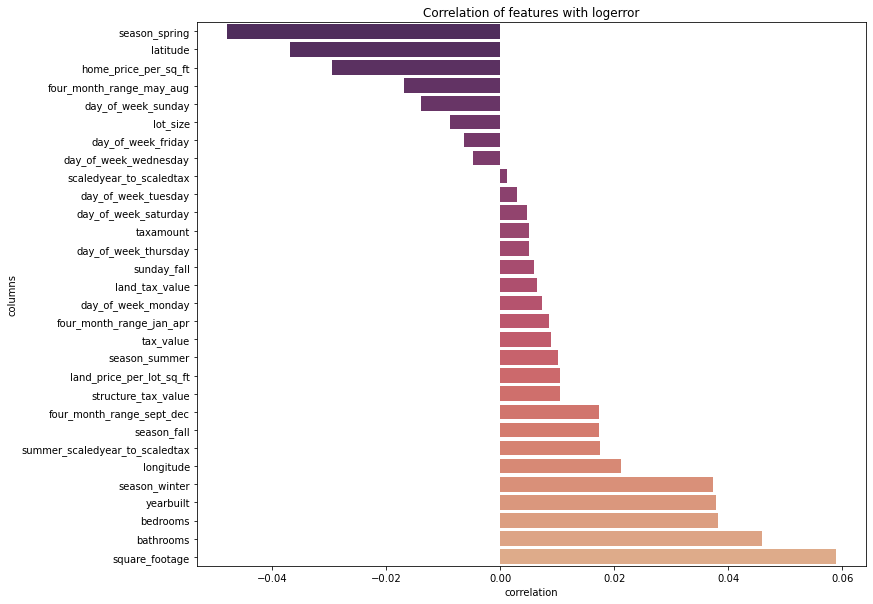

In [9]:
# Showing correlations for all features against logerror
logerr_cor= pd.DataFrame()
plt.figure(figsize=(12,10))
logerr_cor['columns'] = train.corrwith(train['logerror']).index
logerr_cor['correlation'] = train.corrwith(train['logerror']).values
sns.barplot(data = logerr_cor.sort_values('correlation').drop(11), x = 'correlation', y = 'columns', palette='flare_r')
plt.title('Correlation of features with logerror')
plt.show()

As seen above, there are no strong correlations with logerror. The strongest being square_footage at roughly .06 and season spring at roughly .045. I will explain and show engineered features below.

**Feature Engineering:** I decided to create some synthetic features and then rerun these visualizations using those against the target to see how they perform.

- Time of year: split into 4 month blocks - Jan-Apr, May-Aug, Sept-Dec
- Time of year: seasons - Winter, Spring, Summer, Fall
- Day of week: split into days of week and see how it affects things
- Home price per square foot: structure_tax_value / square_footage
- Land price per square foot: land_tax_value / lot_size
- Yearbuilt scaled / taxamount scaled

The only thing that stood out to me from visual inspection of these new features was that *maybe* spring had a lower logerror overall than the rest of the population.

Also maybe four_month_range_sept_dec (or season_fall) might've had a higher logerror overall than the rest of the population. I can test both these observations here with t-tests.


##### Hypothesis 1
alpha = .05

$H_{0}$ = The logerror for homes sold in the Spring months is equal to or higher than homes sold in the other months.

$H_{a}$ = The logerror for homes sold in the Spring months is lower than homes sold in the other months.

In [10]:
# Setting variables
spring_homes = train[train.season_spring == 1]
nonspring_homes = train[train.season_spring != 1]

# Setting alpha
alpha = .05

#Testing for variance with levene
stats.levene(spring_homes.logerror, nonspring_homes.logerror)

LeveneResult(statistic=5.023946754911127, pvalue=0.025008385103655814)

In [11]:
# Based on the Levene test above I need to set equal_var = False

# Running ttest to see if mean of logerror for homes sold in the spring is different than the entire population.
t, p = stats.ttest_ind(spring_homes.logerror, nonspring_homes.logerror, equal_var=False)

t, p

(-7.296600823569362, 3.075859346056581e-13)

In [12]:
p/2 < alpha

True

I reject the null hypothesis, the logerror for homes sold in the Spring months is statistically significant lower than homes sold in the other months.

Visualization below.

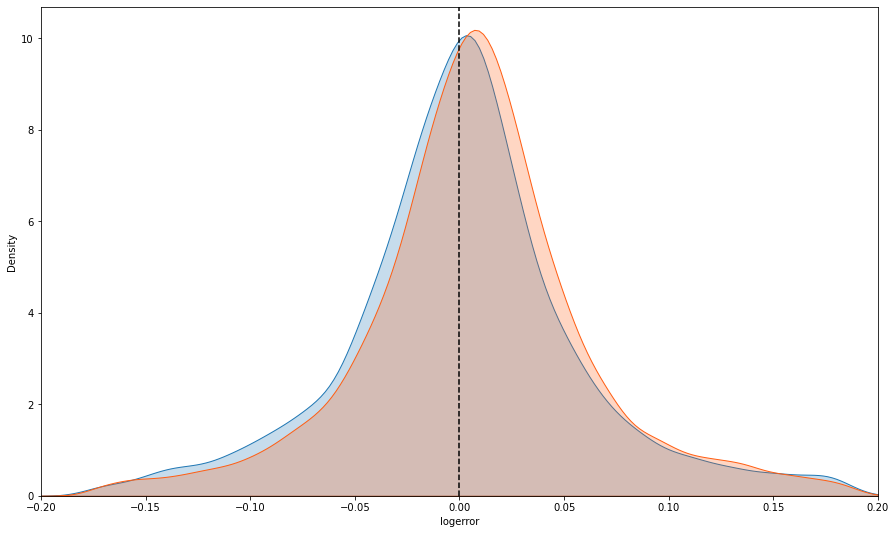

In [13]:
plt.figure(figsize=(15,9))
g = sns.kdeplot(data = spring_homes, x = 'logerror', shade=True)
g = sns.kdeplot(data = nonspring_homes, x = 'logerror', color = '#FF5E13', shade= True)
g.set(xlim=(-.2,.2))
plt.axvline(0, c='black', ls = '--')
plt.show()

##### Hypothesis 2
alpha = .05

$H_{0}$ = The logerror for homes sold in the Fall months is equal to or lower than homes sold in the other months.

$H_{a}$ = The logerror for homes sold in the Fall months is higher than homes sold in the other months.

In [14]:
# Setting variables
fall_homes = train[train.season_fall == 1]
non_fall_homes = train[train.season_fall != 1]

#Testing for variance with levene
stats.levene(fall_homes.logerror, non_fall_homes.logerror)


LeveneResult(statistic=6.2862398452204005, pvalue=0.012174557573114813)

In [15]:
# Based on the Levene test above I need to set equal_var = False

# Running ttest to see if mean of logerror for homes sold in the fall is different than the entire population.
t, p = stats.ttest_ind(fall_homes.logerror, non_fall_homes.logerror, equal_var=False)

t, p

(2.8217642340723366, 0.00483293886081539)

In [16]:
p/2 < alpha

True

I reject the null hypothesis and determine that homes sold in the Fall months have a statistically significant higher logerror than homes sold in the other months. 

Visualization below.

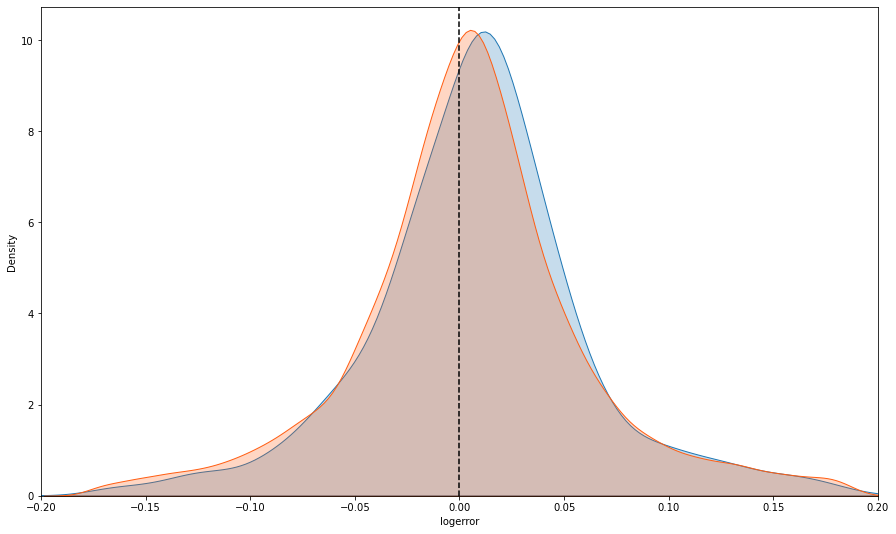

In [17]:
plt.figure(figsize=(15,9))
g = sns.kdeplot(data = fall_homes, x = 'logerror', shade=True)
g = sns.kdeplot(data = non_fall_homes, x = 'logerror', color = '#FF5E13', shade= True)
g.set(xlim=(-.2,.2))
plt.axvline(0, c='black', ls = '--')
plt.show()

##### Takeaways
From these two hypothesis tests I can determine the following.
- Homes sold in the Spring have a statistically signficant logerror that is lower than the rest of the year.
- Homes sold in the Fall have a statistically signficant logerror that is higher than the rest of the year.

I will include both of these features in my final model.

## Clustering
As part of exploration, I will cluster to try to find some new features.

<AxesSubplot:xlabel='logerror', ylabel='Count'>

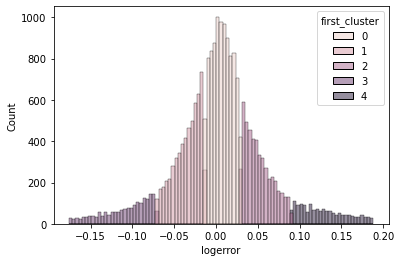

In [18]:
# Making logerror clusters
X = train_scaled[['logerror']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

train_scaled['first_cluster'] = kmeans.predict(X)
sns.histplot(data = train_scaled, x = 'logerror', hue =train_scaled.first_cluster)

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

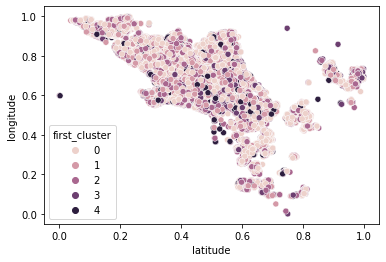

In [19]:
# Running with lat and long to see if there are any patterns.
sns.scatterplot(data = train_scaled, x = 'latitude', y='longitude', hue =train_scaled.first_cluster)

No apparent patterns.

Instead of shooting blindly in the dark, I'm going to exhaustively iterate through clusters to find the best peforming clusters for predicting logerror.

I made a function called cluster_finder which iteratively runs a KMeans clustering algorithm by randomly pairing features together. It has a few settings to allow you to tweak hyperparameters of the KMeans algorithm. If it finds any specific cluster that has a mean that is above or below a specified target variable's standard  devation it will plot out a kdeplot showing the cluster grouping and values. At the end, it prints the max and min  performing feature grouping which is where the single lowest or highest cluster was found.

- I explored 3 and 4 cluster groupings which consisting of 2, 3, and 4 features. I ran roughly 50,000 iterations.

## Visualizing the best clusters

I'm now going to visualize the two best performing clusters some.
<!-- I'm going to create two more synthetic features using the best max performing and the best min performing clusters here: -->

- The best maximum performing feature group was ['season_summer', 'scaledyear_to_scaledtax']

- The best minimum performing feature group was ['day_of_week_sunday', 'season_fall']

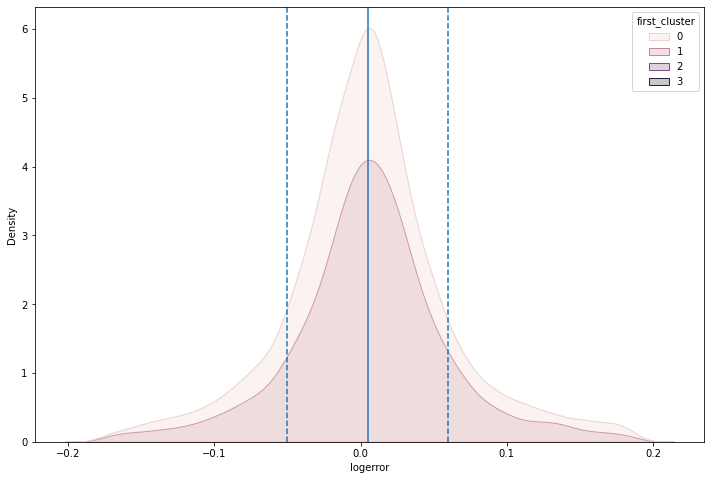

In [20]:
# Creating the cluster for season_summer and scaledyear_to_scaledtax
X = train_scaled[['season_summer', 'scaledyear_to_scaledtax']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
train_scaled['first_cluster'] = kmeans.predict(X)

# Visualizing the the best max feature group.
plt.figure(figsize=(12,8))
sns.kdeplot(data = train_scaled, x = 'logerror', hue =train_scaled.first_cluster, shade = True)
plt.axvline(.004875)
plt.axvline((.004875+0.055084), ls='--')
plt.axvline((.004875-0.055084), ls = '--')
plt.show()

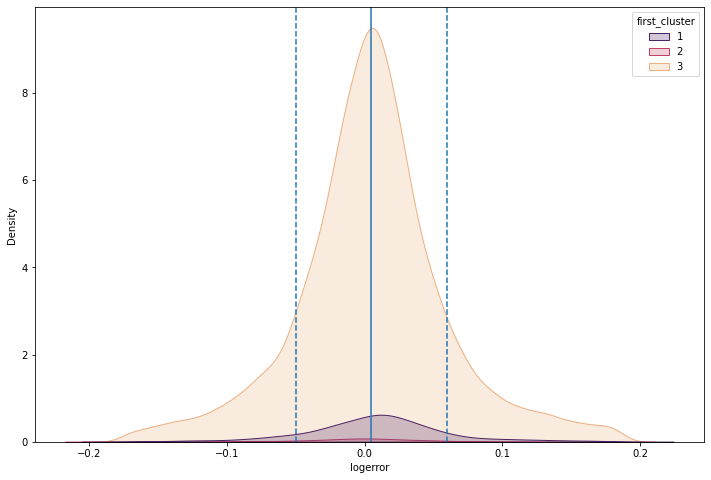

In [21]:
# Creating the cluster for day_of_week_sunday and season_fall
X = train_scaled[['day_of_week_sunday', 'season_fall']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
train_scaled['first_cluster'] = kmeans.predict(X)

plt.figure(figsize=(12,8))
sns.kdeplot(data = train_scaled, x = 'logerror', hue =train_scaled.first_cluster, shade = True, palette= 'flare_r')
plt.axvline(.004875)
plt.axvline((.004875+0.055084), ls='--')
plt.axvline((.004875-0.055084), ls = '--')
plt.show()

I need to hypothesis test these some.

Upon investigation I found sunday_fall with a value of .5 looked to be the biggest influence. I also found summer_scaledyear_to_scaledtax with a value of 1.0 to be an influencer on logerror. I'll test them here.

##### Hypothesis 3
alpha = .05

$H_{0}$ = The logerror for homes with a value of .05 in the sunday_fall feature is less than or equal to homes in the rest of the dataset.

$H_{a}$ = The logerror for homes with a value of .05 in the sunday_fall feature is higher than homes in the rest of the dataset.

In [22]:
# Setting variables
sunday_fall_05 = train_scaled[train_scaled.sunday_fall == .5]
sunday_fall_rest = train_scaled[train_scaled.sunday_fall != .5]

# Setting an alpha
alpha = .05

#Testing for variance with levene
stats.levene(sunday_fall_05.logerror, sunday_fall_rest.logerror)

LeveneResult(statistic=6.2862398452204005, pvalue=0.012174557573114813)

In [23]:
# Based on the Levene test above I need to set equal_var = False

# Running ttest to see if mean of logerror for homes sold in the spring is different than the entire population.
t, p = stats.ttest_ind(sunday_fall_05.logerror, sunday_fall_rest.logerror, equal_var=False)

t, p

(2.8217642340723366, 0.00483293886081539)

In [24]:
p/2 < alpha

True

I reject the null hypothesis, the logerror for homes with a value of .05 in the sunday_fall feature is higher than homes in the rest of the dataset.

Visualization below.

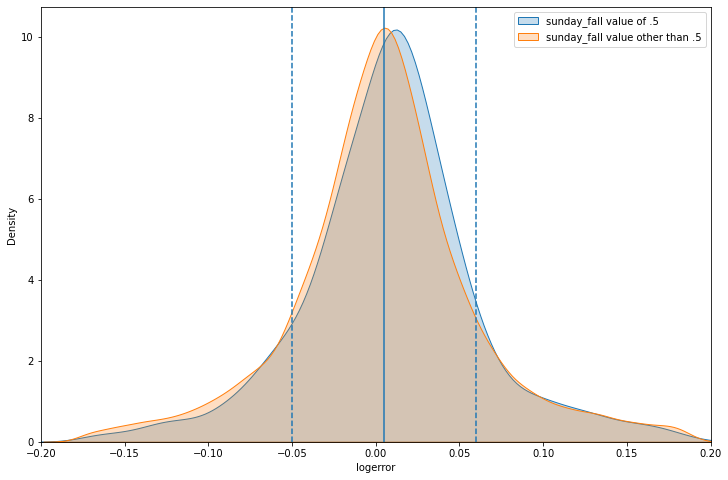

In [25]:
plt.figure(figsize=(12,8))
g = sns.kdeplot(data = sunday_fall_05, x = 'logerror',shade=True, label="sunday_fall value of .5")
g = sns.kdeplot(data = sunday_fall_rest, x = 'logerror', shade=True, label='sunday_fall value other than .5')
g.set(xlim=(-.2,.2))
g.legend()
plt.axvline(.004875)
plt.axvline((.004875+0.055084), ls='--')
plt.axvline((.004875-0.055084), ls = '--')
plt.show()

##### Hypothesis 4
alpha = .05

$H_{0}$ = The logerror for homes with a value of 1.0 in the summer_scaledyear_to_scaledtax feature is less than or equal to homes in the rest of the dataset.

$H_{a}$ = The logerror for homes with a value of 1.0 in the summer_scaledyear_to_scaledtax feature is higher than homes in the rest of the dataset.

In [26]:
# Setting variables
summer_scaledyear_to_scaledtax_1 = train_scaled[train_scaled.summer_scaledyear_to_scaledtax == 1.0]
summer_scaledyear_to_scaledtax_rest = train_scaled[train_scaled.summer_scaledyear_to_scaledtax != 1.0]

# Setting an alpha
alpha = .05
#Testing for variance with levene
stats.levene(summer_scaledyear_to_scaledtax_1.logerror, summer_scaledyear_to_scaledtax_rest.logerror)

LeveneResult(statistic=28.402091671861154, pvalue=9.946315695956174e-08)

In [27]:
# Based on the Levene test above I need to set equal_var = False

# Running ttest to see if mean of logerror for homes sold in the spring is different than the entire population.
t, p = stats.ttest_ind(sunday_fall_05.logerror, sunday_fall_rest.logerror, equal_var=False)

t, p

(2.8217642340723366, 0.00483293886081539)

In [28]:
p/2 < alpha

True

I reject the null hypothesis, the logerror for homes with a value of .05 in the sunday_fall feature is higher than homes in the rest of the dataset.

Visualization below.

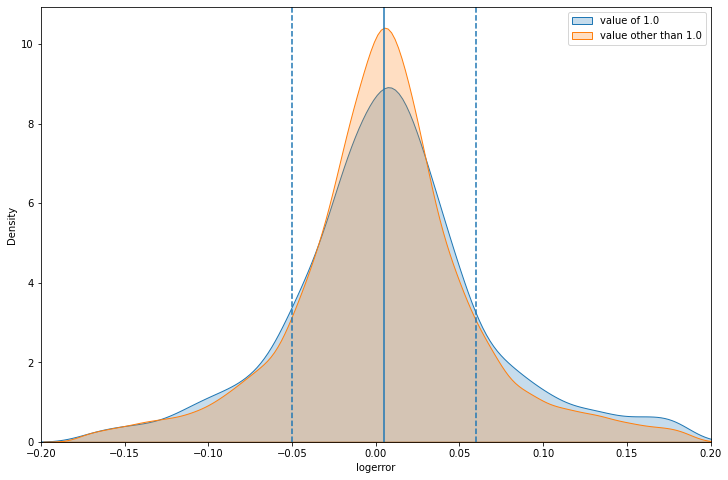

In [29]:
plt.figure(figsize=(12,8))
g = sns.kdeplot(data = summer_scaledyear_to_scaledtax_1, x = 'logerror',shade=True, label="value of 1.0")
g = sns.kdeplot(data = summer_scaledyear_to_scaledtax_rest, x = 'logerror', shade=True, label='value other than 1.0')
g.set(xlim=(-.2,.2))
g.legend()
plt.axvline(.004875)
plt.axvline((.004875+0.055084), ls='--')
plt.axvline((.004875-0.055084), ls = '--')
plt.show()

The final test I want to do is visualize the logerror by county since this was a significant factor in estimating the taxvalue of the home.

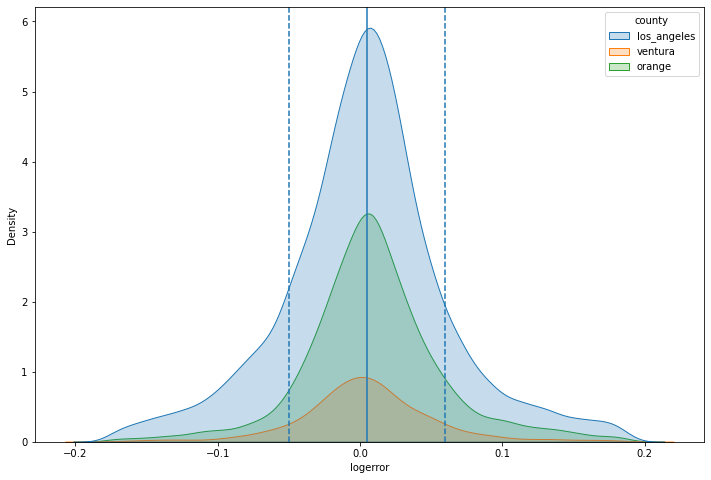

In [30]:
plt.figure(figsize=(12,8))
sns.kdeplot(data = train_scaled, x = 'logerror', hue =train_scaled.county,shade=True)
plt.axvline(.004875)
plt.axvline((.004875+0.055084), ls='--')
plt.axvline((.004875-0.055084), ls = '--')
plt.show()

##### Hypothesis 5
alpha = .05

$H_{0}$ = The logerror for homes in Ventura county is less than or equal to homes in the rest of the dataset.

$H_{a}$ = The logerror for homes in Ventura county is higher than homes in the rest of the dataset.

In [31]:
# Setting variables
la_county = train_scaled[train_scaled.county == 'los_angeles']
not_la_county = train_scaled[train_scaled.county != 'los_angeles']

# Setting an alpha
alpha = .05
#Testing for variance with levene
stats.levene(la_county.logerror, not_la_county.logerror)

LeveneResult(statistic=226.0825624123209, pvalue=7.336632960121714e-51)

In [32]:
# Based on the Levene test above I need to set equal_var = False

# Running ttest to see if mean of logerror for homes sold in the spring is different than the entire population.
t, p = stats.ttest_ind(la_county.logerror, not_la_county.logerror, equal_var=False)

t, p

(-6.688584659194983, 2.311108119757076e-11)

In [33]:
p/2 < alpha

True

Even though the p value supports significance, the negative direction of the t value ndicates that I cannot reject the null hypothesis, the logerror for homes in ventura county is higher than homes in the rest of the dataset.

Visualization below.

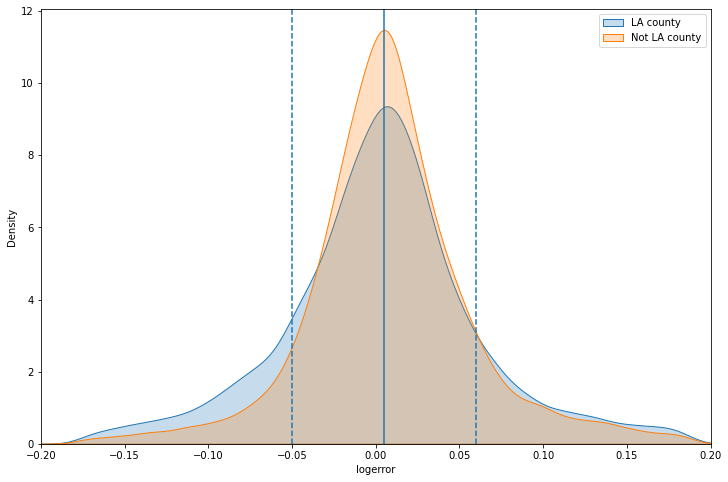

In [34]:
plt.figure(figsize=(12,8))
g = sns.kdeplot(data = la_county, x = 'logerror',shade=True, label="LA county")
g = sns.kdeplot(data = not_la_county, x = 'logerror', shade=True, label='Not LA county')
g.set(xlim=(-.2,.2))
g.legend()
plt.axvline(.004875)
plt.axvline((.004875+0.055084), ls='--')
plt.axvline((.004875-0.055084), ls = '--')
plt.show()

# Exploration Takeaways

- When regression modeling to find logerror I want to use the following two columns from my manual feature engineering as I found them to be statistically significant when looking at logerror:
    - season_spring
    - season_fall
    
- I also want to use the following two synthetic columns when modeling to find logerror as they were found to have statistically different logerrors; these were found through KMeans clustering:
    - summer_scaledyear_to_scaledtax
    - sunday_fall
    
- The biggest influencer on tax_value of the homes as found in a previous project was county, so I will want to try separate models for each county in the end to see if these result in the best model. 
    - Of note, the county did not seem to be a statistically significant indicator of logerror so it may not produce as good results as I found for tax_value.

# Modeling 


In [35]:
# Setting features to use in the model
features = ['bathrooms', 'bedrooms', 'square_footage','tax_value', 'season_spring','season_fall',
            'summer_scaledyear_to_scaledtax','sunday_fall','lot_size','yearbuilt']

# Setting X and y for train, validate and test.

X_train = train_scaled[features]
y_train = pd.DataFrame(train_scaled.logerror)

X_validate = validate_scaled[features]
y_validate = pd.DataFrame(validate_scaled.logerror)

X_test = test_scaled[features]
y_test = pd.DataFrame(test_scaled.logerror)

I ran a number of models; displaying results and visualizations below.

In [36]:
# Pulling in model results
model_results = pd.read_csv('model_results.csv')
model_results['cumulative_RMSE'] = model_results.train_RMSE + model_results.validate_RMSE
model_results['diff_RMSE'] = model_results.train_RMSE - model_results.validate_RMSE
model_results

,model,train_RMSE,validate_RMSE,cumulative_RMSE,diff_RMSE
0,train_mean,0.055492,0.054755,0.110247,0.000737
1,train_median,0.055493,0.054754,0.110247,0.000738
2,linear_regression_ols,0.055270,0.054481,0.109751,0.000789
3,lasso_lars,0.055492,0.054755,0.110247,0.000737
4,polynomial_regression,0.055138,0.054489,0.109628,0.000649
5,least_angle_lars,0.055270,0.054481,0.109751,0.000789
6,coordinate_descent_lasso,0.055492,0.054755,0.110247,0.000737
7,least_angle_LassoLarsCV,0.055273,0.054478,0.109750,0.000795
8,least_angle_LassoLarsIC,0.055272,0.054478,0.109749,0.000794
9,ridge_regressor,0.055270,0.054481,0.109751,0.000789


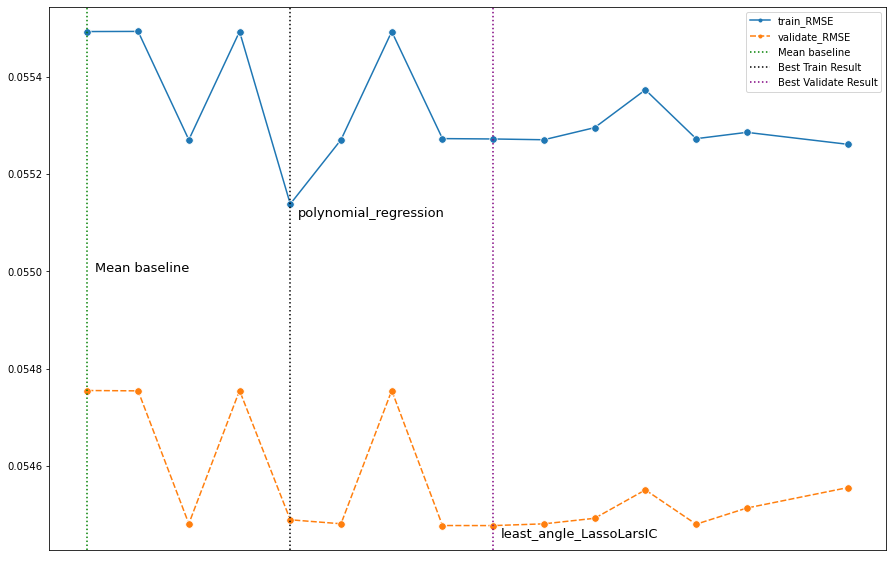

In [37]:
model.plot_all_models(model_results)

So the best performing holistic model for predicting logerror seems to be polynomial regression with a validate RMSE of .054489 which beats the mean validate RMSE of 0.054755. This is an improvement of 0.000266 logerror. This validate RMSE of .054489 is my new baseline to beat when trying with models broken out by county.

## Individual county models

I once agaiin wanted to try some individual county models.

In [38]:
# Setting variables for each individual county and splits for train, validate, test.
train_la, train_orange, train_ventura = model.county_train_split(train_scaled)
validate_la, validate_orange, validate_ventura = model.county_validate_split(validate_scaled)
test_la, test_orange, test_ventura = model.county_test_split(test_scaled)

X_train_la, y_train_la, X_train_orange, y_train_orange, X_train_ventura, y_train_ventura = model.county_train_x_y(train_la, train_orange, train_ventura, features)
X_validate_la, y_validate_la, X_validate_orange, y_validate_orange, X_validate_ventura, y_validate_ventura = model.county_validate_x_y(validate_la, validate_orange, validate_ventura, features)
X_test_la, y_test_la, X_test_orange, y_test_orange, X_test_ventura, y_test_ventura = model.county_test_x_y(test_la, test_orange, test_ventura, features)

# Creating and evaluating the models.
y_train_la, y_validate_la, y_test_la = model.la_county_model(X_train_la, y_train_la, X_validate_la, y_validate_la, X_test_la, y_test_la)
y_train_orange, y_validate_orange, y_test_orange = model.orange_county_model(X_train_orange, y_train_orange, X_validate_orange, y_validate_orange, X_test_orange, y_test_orange)
y_train_ventura, y_validate_ventura, y_test_ventura = model.ventura_county_model(X_train_ventura, y_train_ventura, X_validate_ventura, y_validate_ventura, X_test_ventura, y_test_ventura)

RMSE for Polynomial Model for LA county

Training/In-Sample:  0.058205720134046686 
Validation/Out-of-Sample:  0.05779715505776029

RMSE for Polynomial Model for Orange county

Training/In-Sample:  0.04923583446495609 
Validation/Out-of-Sample:  0.048745828255852344

RMSE for Polynomial Model for Orange county

Training/In-Sample:  0.04899436321295905 
Validation/Out-of-Sample:  0.050206201328466475


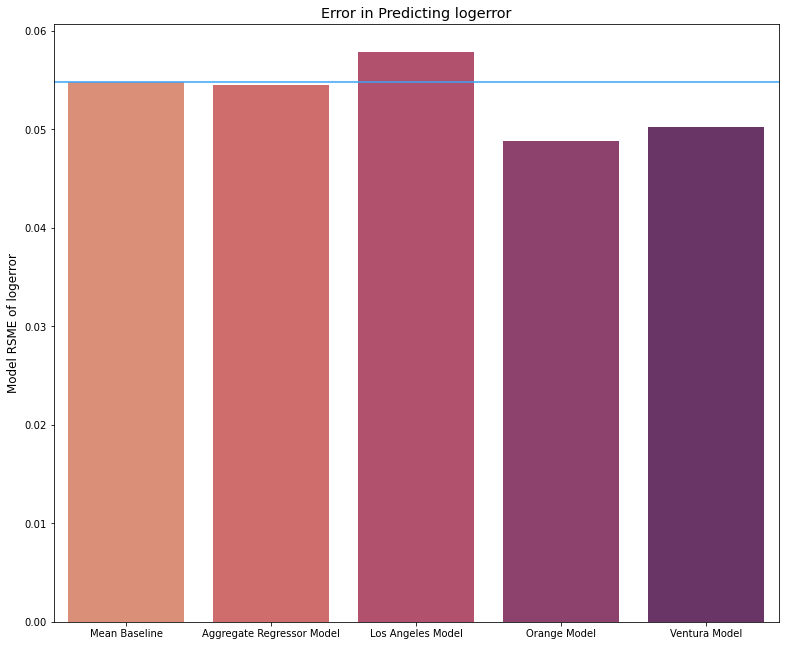

In [39]:
# Plotting the individual county model results
model.validate_results_plot(model_results, y_validate_la, y_validate_orange, y_validate_ventura)

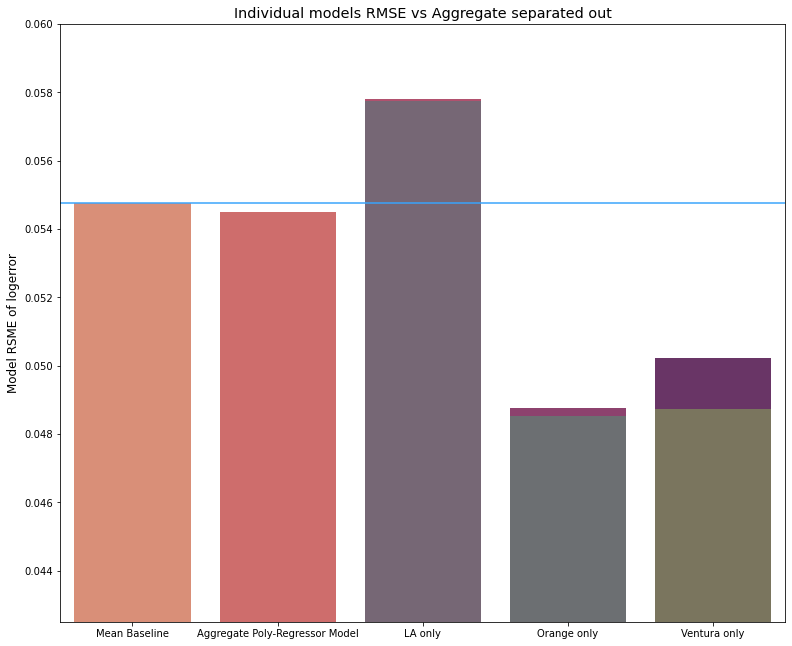

In [40]:
# Plotting individual county model results agains the aggregate model results split by county.
y_test = model.comparison_plot(model_results, X_train, X_validate, X_test, y_train, y_validate, y_test, validate_scaled, y_validate_la, y_validate_orange, y_validate_ventura)

**Peculiar finding** 
After seeing the results of the individual models I also wanted to see the results of the original aggregated model but split by county. Somehow the aggregated model when split by county actually beats the individual models created. 

I don't truly understand this, but as it stands I will be using the Aggregate Polynomial Regression model for testing and I will analyze the results overall as well as split by county.

### Verifying the final model on test

In [41]:
# Making predictions for the out of sample/test dataset with the final model and showing RMSE results.
rmse_aggregate_test, la_only_test_RMSE, orange_only_test_RMSE, ventura_only_test_RMSE = model.final_model_test(y_test, test_scaled)


RMSE for Aggregate Polynomial Model on 
Test/Out-of-Sample:  0.05459730304169651


RMSE for Aggregate Polynomial Model for Los Angeles county on
Test/Out-of-Sample:  0.05710058417165183

RMSE for Aggregate Polynomial Model for Orange county on
Test/Out-of-Sample:  0.050176321921967984

RMSE for Aggregate Polynomial Model for Ventura county on
Test/Out-of-Sample:  0.049233975325429676


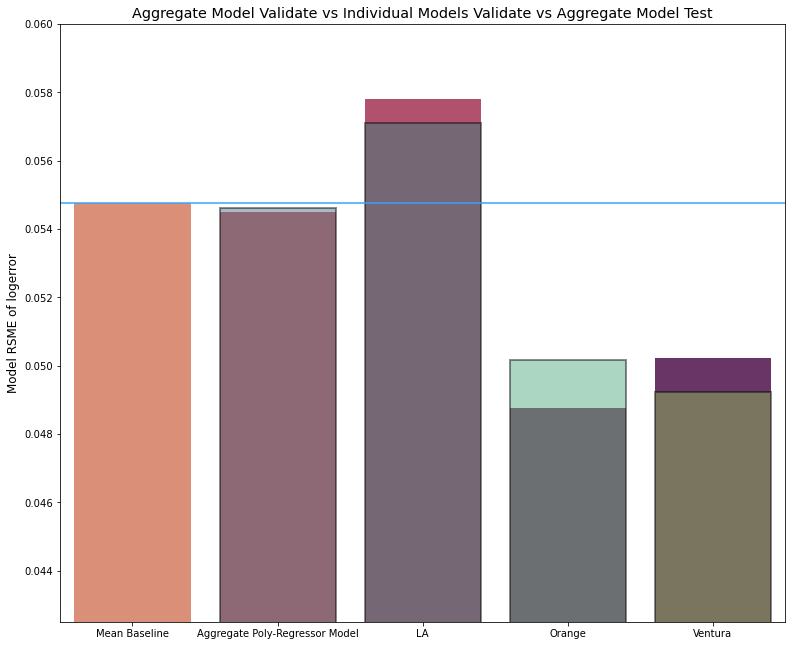

In [42]:
# Visualizing the model results and comparing to baselines previously set on test below.

model.final_comparison_plot(model_results, X_train, X_validate, X_test, y_train, y_validate, y_test, validate_scaled, y_validate_la, y_validate_orange, y_validate_ventura, rmse_aggregate_test, la_only_test_RMSE, orange_only_test_RMSE, ventura_only_test_RMSE)

### Modeling Final Takeaways

The best performing model I arrived at was a polynomial regression model with a degree of 2.
- RMSE of mean baseline: 0.0548
- RMSE of my model on test/out-of-sample data: 0.0546
- My final model beat mean RMSE by .0002

# Conclusions, Recommendations, Next Steps
I developed an ML Regression model that beat the mean baseline on out of sample data.
- Nothing I found was a great driver/predictor of logerror. 
- If there is any specific combination of features that might be clustered to better predict logerror I was not able to find it.

The interactions of the data may either be too complex or the data itself too random to accurately predict using a linear regression model. 
    
##### Odd results were found:
- An aggregate model performed better than individual models for each county.
    - As suspected and shown in my statistical testing, county is not a good predictor of logerror, though some other feature category might yield more fruitful results when creating multiple models.

- Given more time, I'd like to further investigate by creating new models based on other categories besides county to see if I might identify better predictors of logerror.

#### Next Steps and Recommendations:
Deeper domain expertise of both the housing market and specifically the Zillow algorithm is needed to better refine any predictive models made in the future.